In [12]:
import numpy as np
import numpy.random as rv
import numpy.linalg as lin
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
from matplotlib import rcParams

In [13]:
# set MLflow
import mlflow
import dagshub
dagshub.init(repo_owner='peng-ju', repo_name='Power-of-Choice', mlflow=True)
mlflow.set_tracking_uri="https://dagshub.com/peng-ju/Power-of-Choice.mlflow"
mlflow.set_experiment(experiment_name="Quadratic_optimization")

# with mlflow.start_run():
#     for epoch in range(0, 3):
#         mlflow.log_metric(key="quality", value=2 * epoch, step=epoch)

Repository initialized!

<Experiment: artifact_location='mlflow-artifacts:/984c34e5aef349f79f5c3689fa03cb69', creation_time=1699829491523, experiment_id='3', last_update_time=1699829491523, lifecycle_stage='active', name='Quadratic_optimization', tags={}>

In [14]:
def get_idxs_users_rhos(p_dat, it, currcli_loss, args, x_temp, all_mult_mat, x_mult_opt, loc_fmin, glob_loss, local_optloss, rhotilde_deno):
    '''
    Get the estimate rhos (not theoretical ones) by setting the range of $w$ as the $\overbar{w}$s for each iteration
    :return: estimate of rhobar, rhotilde
    
    produce idxs_users, which is the selected clients for next iteration
    '''
    size = args.num_users*args.frac
    selidxs_freq = np.zeros(args.num_users)
    p_dat = np.ndarray.flatten(p_dat)
    # print(args.__dict__)
    for ii in range(it + 1):
        if args.seltype == 'rand':
            idxs_users = np.random.choice(args.num_users, p=p_dat, size=int(size), replace=True)
        elif args.seltype == 'powd':
            rnd_idx = np.random.choice(args.num_users, size=args.powd, replace=False, p=p_dat)
            repval = list(zip([currcli_loss[i] for i in rnd_idx], rnd_idx))
            repval.sort(key=lambda x: x[0], reverse=True)
            rep = list(zip(*repval))
            # select top [size] clients based on the loss
            idxs_users = rep[1][:int(size)]
        elif args.seltype == 'adapow-d':
            rnd_idx = np.random.choice(args.num_users, size=args.powd, replace=False, p=p_dat)
            repval = list(zip([currcli_loss[i] for i in rnd_idx], rnd_idx))
            repval.sort(key=lambda x: x[0], reverse=True)
            rep = list(zip(*repval))
            # select top [size] clients based on the loss
            idxs_users = rep[1][:int(size)]

        if ii != it:
            for j in idxs_users:
                selidxs_freq[j] += 1

    # Get rho values
    rhobar = np.inf
    for i in range(args.le):
        le_currloss = callocloss(np.ndarray.flatten(np.transpose(x_temp[i])), all_mult_mat, x_mult_opt, args)
        le_numi = (sum(np.multiply(selidxs_freq/it, np.array(le_currloss)-np.array(loc_fmin))))\
                  /(args.frac*args.num_users)
        le_loss = (np.sum(np.multiply(le_currloss, p_dat)) - glob_loss)\
                  -sum(np.multiply(p_dat,loc_fmin)) # Global loss F(w^i)
        if rhobar>=le_numi/le_loss:
            rhobar = le_numi/le_loss

    rhotilde_numi = sum(np.multiply(selidxs_freq/it, np.array(local_optloss)-np.array(loc_fmin)))/\
                    (args.frac*args.num_users)
    rhotilde = rhotilde_numi / rhotilde_deno

    return idxs_users, rhobar, rhotilde

def get_idxs_users(p_dat, it, currcli_loss, args):
    '''
    :return: idxs_users, which is the selected clients for next iteration
    '''
    size = args.num_users*args.frac
    selidxs_freq = np.zeros(args.num_users)
    p_dat = np.ndarray.flatten(p_dat)
    # print(args.__dict__)
    for ii in range(it + 1):
        if args.seltype == 'rand':
            idxs_users = np.random.choice(args.num_users, p=p_dat, size=int(size), replace=True)
        elif args.seltype == 'powd':
            rnd_idx = np.random.choice(args.num_users, size=args.powd, replace=False, p=p_dat)
            repval = list(zip([currcli_loss[i] for i in rnd_idx], rnd_idx))
            repval.sort(key=lambda x: x[0], reverse=True)
            rep = list(zip(*repval))
            # select top [size] clients based on the loss
            idxs_users = rep[1][:int(size)]
        elif args.seltype == 'adapow-d':
            rnd_idx = np.random.choice(args.num_users, size=args.powd, replace=False, p=p_dat)
            repval = list(zip([currcli_loss[i] for i in rnd_idx], rnd_idx))
            repval.sort(key=lambda x: x[0], reverse=True)
            rep = list(zip(*repval))
            # select top [size] clients based on the loss
            idxs_users = rep[1][:int(size)]

        if ii != it:
            for j in idxs_users:
                selidxs_freq[j] += 1
    
    return idxs_users

def callocloss(x,H,e, args):
    """
    equation (87) of the supplementary material
    L = (Hx - e)**2 
    
    x: current parameters
    H: fixed matrix for the quadratic objective function
    e: fixed vector
    """
    ans = []

    if len(np.shape(x))==1 or np.shape(x)[0]==1:
        for i in range(args.num_users):
            term1 = np.matmul(np.matmul(x, H[i]), np.transpose(x)) / 2
            term2 = -np.matmul(x, np.transpose(e[i][:]))
            term3 = np.matmul(np.matmul(e[i][:], lin.inv(H[i])), np.transpose(e[i][:])) / 2

            ans.append(term1+term2+term3)

    else:
        for i in range(args.num_users):
            term1 = np.matmul(np.matmul(x[i][:], H[i]), np.transpose(x[i][:])) / 2
            term2 = -np.matmul(x[i][:], np.transpose(e[i][:]))
            term3 = np.matmul(np.matmul(e[i][:], lin.inv(H[i])), np.transpose(e[i][:])) / 2

            ans.append(term1+term2+term3)

    return ans

In [15]:
class Args_parser():
    def __init__(self, seltype = "rand", powd = 30, num_users = 30, epochs = 50000, get_rhos=False):
        self.name = "default"
        self.num_users = num_users # 30
        self.frac = 0.1
        self.powd = powd # 30
        self.alpha = 3 # control the distribution
        self.seed = 2
        self.high = 9
        self.lr = 0.00002
        self.le = 2
        self.epochs = epochs # 15000
        self.seltype = seltype # "rand"
        self.dim = 5
        self.eq = 0
        self.get_rhos = get_rhos

In [16]:
def quadratic_optimization(seltype = "rand", powd = 30, num_users = 30, epochs = 15000, get_rhos = False):
    with mlflow.start_run():
        args = Args_parser(seltype = seltype, powd = powd, num_users = num_users, epochs = epochs, get_rhos = get_rhos)
    
        # num_users: number of clients
        # frac: C fraction of client is chosen for each iteration
        size = args.num_users*args.frac 
        rnd = rv.RandomState(args.seed)
    
        # optimum result for each local client: number of client * dimension of data
        x_mult_opt = rnd.random_sample((args.num_users,args.dim))*100
    
        # array to produce H_k
        x_mult_mat = rnd.random_sample(args.num_users)*args.high
    
        all_mult_mat = {}
        loc_min, loc_fmin = [], []
    
        for k in range(args.num_users):
            # create diagonal matrix H_k = h_k * I
            all_mult_mat[k] = np.diag(np.full(args.dim,x_mult_mat[k]))
            # exact local minimum: inv(H_k) * e_k for equation (87)
            loc_min.append(np.matmul(x_mult_opt[k][:], lin.inv(all_mult_mat[k])))   # x_k^*
    
        # Get Datasize
        # produce a 1d array: probability of each client to be choosen
        if args.eq == 1:
            p_dat = np.ones(args.num_users) / args.num_users
    
        else:
            p_dat = rnd.power(args.alpha, args.num_users)
            p_dat = p_dat/sum(p_dat)
    
        opt1 = np.sum(p_dat * np.array(x_mult_mat))
        opt2 = np.matmul(p_dat.T, x_mult_opt)
        # globle minimum
        glob_min = np.matmul(opt2, lin.inv(np.diag(np.full(args.dim,opt1))))      # x^*
    
    
        local_optloss = callocloss(glob_min, all_mult_mat, x_mult_opt, args)
        loc_fmin = callocloss(loc_min, all_mult_mat, x_mult_opt, args)
        # Loss is not zero after global optimization
        glob_loss = np.sum(np.multiply(p_dat, local_optloss))
    
        disto_glob, x_global = [], []
        cli_loss, currcli_loss, global_loss = [], [], []
        rhobar_dat, rhotilde_dat = [], []
        rhotilde_deno = sum(np.multiply(local_optloss,p_dat))-sum(np.multiply(loc_fmin,p_dat))
    
        # initilize gobal parameter: w
        x_global.append(rnd.randn(1, args.dim)*100)
    
        currcli_loss = callocloss(np.ndarray.flatten(np.transpose(x_global[0][:])),all_mult_mat,x_mult_opt, args)
    
        cli_loss.append(currcli_loss)
        # total loss weighted by p_data
        loss = np.sum(np.multiply(currcli_loss, p_dat))-glob_loss                          # Global loss F(w^i)
        global_loss.append(loss)
    
        # record selected frequency for each clients
        sel_freq = np.zeros(args.num_users)
        all_sel_freq = []
    
        lr = args.lr
    
        new_global = 0
        for epoch in tqdm(range(args.epochs)):
                # Select users
                if epoch ==0:           # If it is the first epoch so we first randomly select the users by their data size
                    init = np.random.RandomState(1)
                    if args.seltype == 'rand': # why seltype change replace or not
                        idxs_users = init.choice(args.num_users, p=p_dat, size=int(size), replace=True)
    
                    else:
                        idxs_users = init.choice(args.num_users, p=p_dat, size=int(size), replace=False)
    
                '''
                if epoch==4000 or epoch==8000:
                    lr /= 4
                    print('update learning rate to', args.lr)
                '''
                disto_glob.append(lin.norm(glob_min-x_global[epoch], ord=2))
    
                # For Selected Clients: local update (epoch, batch) & data accum.
                # le: local updates for each client
                x_temp = {k:np.zeros(np.shape(x_global[epoch][:])) for k in range(int(args.le))}
                for j, idx in enumerate(idxs_users):
                    idx = int(idx)
                    tmp = x_global[epoch][:]
                    for i in range(args.le):
                        tmp = tmp - lr * (np.matmul(tmp,all_mult_mat[idx]) - x_mult_opt[idx][:])
                        x_temp[i]+=tmp
    
                        # average of all selected clients
                        if j == int(size)-1:
                            x_temp[i]/=size
    
                    sel_freq[idx]+=1
    
                all_sel_freq.append(list(sel_freq))
                # only take the result from the latest local update
                x_global.append(x_temp[args.le-1]) 
    
                currcli_loss = callocloss(np.ndarray.flatten(np.transpose(x_global[epoch+1][:])), all_mult_mat, x_mult_opt, args)
                cli_loss.append(currcli_loss)
                loss = np.min(np.sum(np.multiply(currcli_loss, p_dat))-glob_loss,0)        # Global loss F(w^i)
                global_loss.append(loss)
                # MLflow
                mlflow.log_metric(key="global_loss", value=loss, step=epoch)
                
                if args.seltype == "adapow-d":
                    # args.epochs = 50000, d_rand = size = 10, rgs.num_users = 100,  
                    # args.powd = int(max(size, int(args.num_users/args.epochs * (args.epochs-epoch))))
                    
                    # powd_list = [args.num_users, args.num_users//2, args.num_users//4, args.num_users//10]
                    # args.powd = powd_list[epoch//(args.epochs//4 + 1)]
                    
                    # 100, 50, 25, 10
                    # powd_list = [args.num_users, args.num_users//2, args.num_users//4, args.num_users//10]
                    # args.powd = powd_list[min(epoch//(5000 + 1), 3)]
    
                    # 100, 50, 25, 13, 10
                    powd_list = [args.num_users, args.num_users//2, args.num_users//4, args.num_users//8, args.num_users//10]
                    args.powd = powd_list[min(epoch//(5000 + 1), 4)]
                    
                    # powd_list = [args.num_users, args.num_users//2, args.num_users//4, args.num_users//10]
                    # args.powd = powd_list[min(epoch//(3300 + 1), 3)]
    
                # select the clients for next epoch
                if args.get_rhos == False:
                    idxs_users = get_idxs_users(p_dat, 100, currcli_loss, args)
                else:
                    idxs_users, rhobar, rhotilde = get_idxs_users_rhos(p_dat, it=100, 
                                                                       currcli_loss=currcli_loss, 
                                                                       args=args, x_temp=x_temp, 
                                                                       all_mult_mat=all_mult_mat,
                                                                       x_mult_opt=x_mult_opt,
                                                                       loc_fmin=loc_fmin,
                                                                       glob_loss=glob_loss,
                                                                       local_optloss=local_optloss,
                                                                       rhotilde_deno=rhotilde_deno)
                    rhobar_dat.append(rhobar)
                    rhotilde_dat.append(rhotilde)
    
                # print("idxs_users", idxs_users, "rhobar", rhobar, "rhotilde", rhotilde)
                # print('Epoch', epoch, 'Loss', loss, 'Distance to global minimum', lin.norm(glob_min-x_global[epoch], ord=2))

    if args.get_rhos == False:
        return global_loss
    else:
        return global_loss, np.min(rhobar_dat), np.max(rhotilde_dat)/np.min(rhobar_dat)

# Run above from here to initailize the notebook

# Figure 2(a)

In [ ]:
global_loss_rand_powd30_users30 = quadratic_optimization(seltype = "rand", powd = 30, num_users = 30, epochs = 15000)
global_loss_powd_powd30_users30 = quadratic_optimization(seltype = "powd", powd = 30, num_users = 30, epochs = 15000)
global_loss_powd_powd9_users30 = quadratic_optimization(seltype = "powd", powd = 9, num_users = 30, epochs = 15000)
global_loss_powd_powd6_users30 = quadratic_optimization(seltype = "powd", powd = 6, num_users = 30, epochs = 15000)
global_loss_adapow_powd30_users30 = quadratic_optimization(seltype = "adapow-d", powd = 30, num_users = 30, epochs = 15000)

  0%|▏                                                        | 35/15000 [00:20<2:36:57,  1.59it/s]

/tmp/ipykernel_12619/3113268230.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

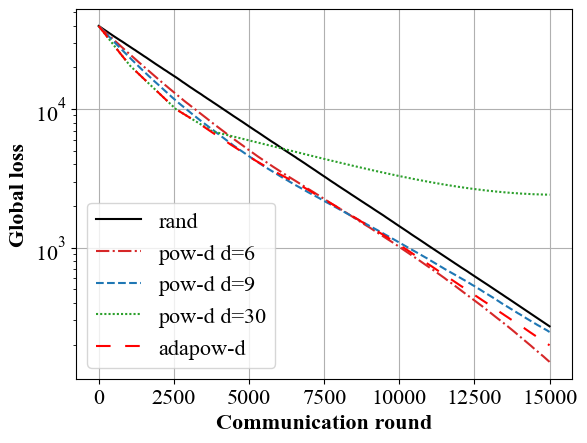

In [50]:
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd30_users30, color="k", ls="-", label="rand")
plt.plot(global_loss_powd_powd6_users30, color=c_t(3), ls="-.", label = "pow-d d=6")
plt.plot(global_loss_powd_powd9_users30, color=c_t(0), ls="--", label = "pow-d d=9")
plt.plot(global_loss_powd_powd30_users30, color=c_t(2), ls=(0, (1, 1)), label = "pow-d d=30")
plt.plot(global_loss_adapow_powd30_users30, color="r", ls="-", dashes=[7, 7], label = "adapow-d")
plt.yscale("log")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

/tmp/ipykernel_12619/3548685577.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

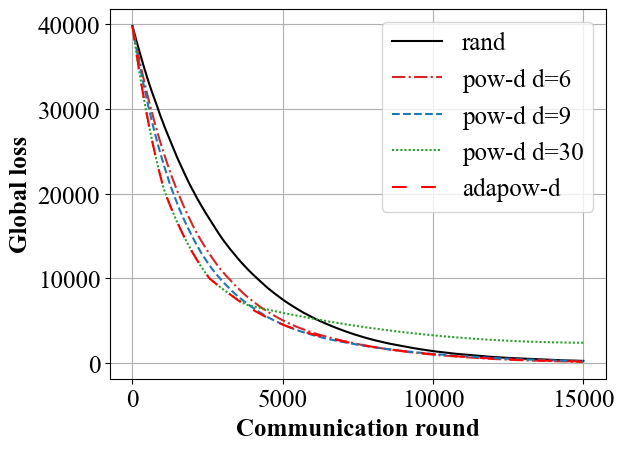

In [49]:
c_t = cm.get_cmap('tab10')
ftsize = 18
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd30_users30, color="k", ls="-", label="rand")
plt.plot(global_loss_powd_powd6_users30, color=c_t(3), ls="-.", label = "pow-d d=6")
plt.plot(global_loss_powd_powd9_users30, color=c_t(0), ls="--", label = "pow-d d=9")
plt.plot(global_loss_powd_powd30_users30, color=c_t(2), ls=(0, (1, 1)), label = "pow-d d=30")
plt.plot(global_loss_adapow_powd30_users30, color="r", ls="-", dashes=[7, 7], label = "adapow-d")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

# Figure 2(b)

In [40]:
global_loss_rand_powd100_users100 = quadratic_optimization(seltype = "rand", powd = 100, num_users = 100, epochs = 15000)
global_loss_powd_powd100_users100 = quadratic_optimization(seltype = "powd", powd = 100, num_users = 100, epochs = 15000)
global_loss_powd_powd30_users100 = quadratic_optimization(seltype = "powd", powd = 30, num_users = 100, epochs = 15000)
global_loss_powd_powd15_users100 = quadratic_optimization(seltype = "powd", powd = 15, num_users = 100, epochs = 15000)
global_loss_adapow_powd100_users100 = quadratic_optimization(seltype = "adapow-d", powd = 100, num_users = 100, epochs = 15000)

100%|███████████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:46<00:00, 140.44it/s]


/tmp/ipykernel_12619/3548621565.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

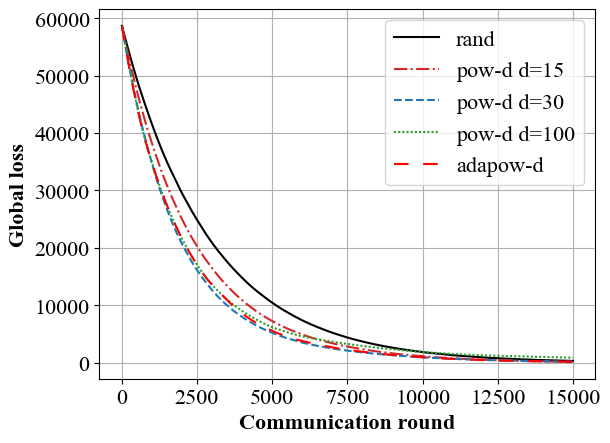

In [51]:
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd100_users100, color="k", ls="-", label="rand")
plt.plot(global_loss_powd_powd15_users100, color=c_t(3), ls="-.", label = "pow-d d=15")
plt.plot(global_loss_powd_powd30_users100, color=c_t(0), ls="--", label = "pow-d d=30")
plt.plot(global_loss_powd_powd100_users100, color=c_t(2), ls=(0, (1, 1)), label = "pow-d d=100")
plt.plot(global_loss_adapow_powd100_users100, color="r", ls="-", dashes=[7, 7], label = "adapow-d")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

/tmp/ipykernel_12619/2172872594.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

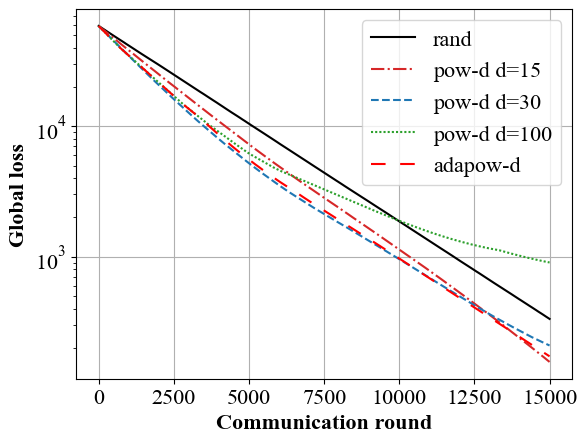

In [52]:
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd100_users100, color="k", ls="-", label="rand")
plt.plot(global_loss_powd_powd15_users100, color=c_t(3), ls="-.", label = "pow-d d=15")
plt.plot(global_loss_powd_powd30_users100, color=c_t(0), ls="--", label = "pow-d d=30")
plt.plot(global_loss_powd_powd100_users100, color=c_t(2), ls=(0, (1, 1)), label = "pow-d d=100")
plt.plot(global_loss_adapow_powd100_users100, color="r", ls="-", dashes=[7, 7], label = "adapow-d")

plt.yscale("log")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

# Figure 2(C)

In [53]:
global_loss_rand_powd100_users100_50000 = quadratic_optimization(seltype = "rand", powd = 100, num_users = 100, epochs = 50000)
global_loss_powd_powd15_users100_50000 = quadratic_optimization(seltype = "powd", powd = 15, num_users = 100, epochs = 50000)

100%|███████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:17<00:00, 194.32it/s]


In [58]:
global_loss_adapow_powd100_users100_50000 = quadratic_optimization(seltype = "adapow-d", powd = 100, num_users = 100, epochs = 50000)

100%|███████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:48<00:00, 173.53it/s]


/tmp/ipykernel_12619/1119066536.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

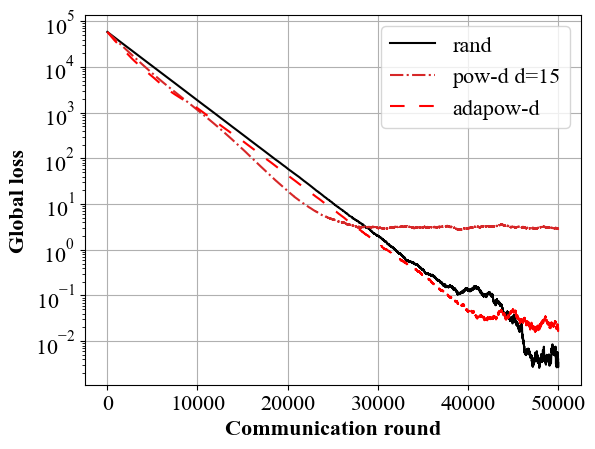

In [55]:
# 100, 50, 25, 10
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd100_users100_50000, color="k", ls="-", label = "rand")
plt.plot(global_loss_powd_powd15_users100_50000, color=c_t(3), ls="-.", label = "pow-d d=15")
plt.plot(global_loss_adapow_powd100_users100_50000, color="r", ls="-", dashes=[7, 7], label = "adapow-d")

plt.yscale("log")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

/tmp/ipykernel_12619/3739170261.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

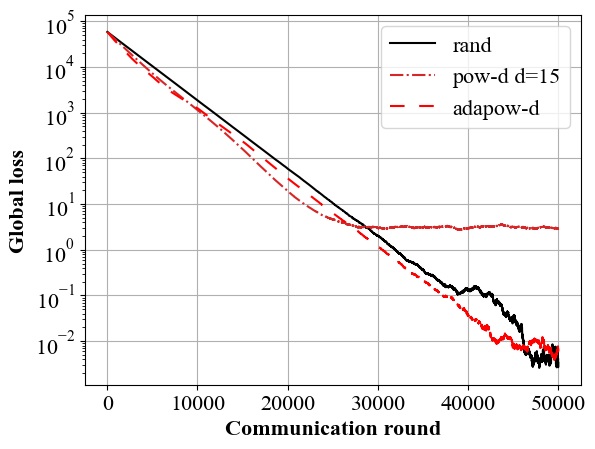

In [195]:
# 100, 50, 25, 12, 10

c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()
plt.plot(global_loss_rand_powd100_users100_50000, color="k", ls="-", label = "rand")
plt.plot(global_loss_powd_powd15_users100_50000, color=c_t(3), ls="-.", label = "pow-d d=15")
plt.plot(global_loss_adapow_powd100_users100_50000, color="r", ls="-", dashes=[7, 7], label = "adapow-d")

plt.yscale("log")

plt.ylabel('Global loss')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

/tmp/ipykernel_12619/3195729627.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

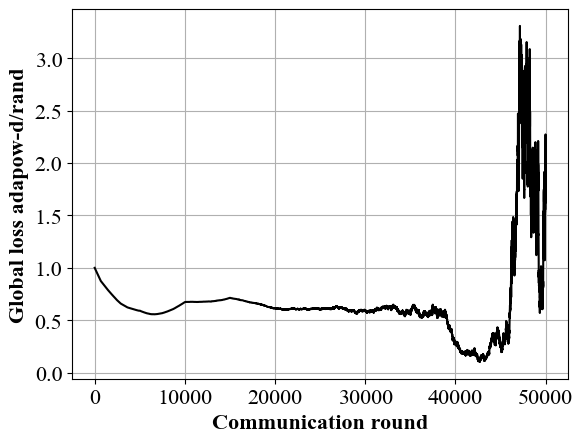

In [196]:
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14

plt.figure()

plt.plot(np.array(global_loss_adapow_powd100_users100_50000)/np.array(global_loss_rand_powd100_users100_50000),color="k", ls="-")

plt.ylabel('Global loss adapow-d/rand')
plt.xlabel('Communication round')
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
# plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

# Figure 2(d)

In [191]:
global_loss_rand_powd30_users30, converge_rand_powd30_users30, bias_rand_powd30_users30 = quadratic_optimization(seltype = "rand", powd = 30, num_users = 30, epochs = 15000, get_rhos = True)
global_loss_powd_powd30_users30, converge_powd_powd30_users30, bias_powd_powd30_users30 = quadratic_optimization(seltype = "powd", powd = 30, num_users = 30, epochs = 15000, get_rhos = True)
global_loss_powd_powd15_users30, converge_powd_powd15_users30, bias_powd_powd15_users30 = quadratic_optimization(seltype = "powd", powd = 15, num_users = 30, epochs = 15000, get_rhos = True)
global_loss_powd_powd9_users30, converge_powd_powd9_users30, bias_powd_powd9_users30 = quadratic_optimization(seltype = "powd", powd = 9, num_users = 30, epochs = 15000, get_rhos = True)
global_loss_powd_powd6_users30, converge_powd_powd6_users30, bias_powd_powd6_users30 = quadratic_optimization(seltype = "powd", powd = 6, num_users = 30, epochs = 15000, get_rhos = True)
global_loss_adapow_powd30_users30, converge_adapow_powd30_users30, bias_adapow_powd30_users30 = quadratic_optimization(seltype = "adapow-d", powd = 30, num_users = 30, epochs = 15000, get_rhos = True)

100%|███████████████████████████████████████████████████████████████████| 15000/15000 [01:32<00:00, 162.81it/s]


In [192]:
global_loss_rand_powd100_users100, converge_rand_powd100_users100, bias_rand_powd100_users100 = quadratic_optimization(seltype = "rand", powd = 100, num_users = 100, epochs = 15000, get_rhos = True)
global_loss_powd_powd100_users100, converge_powd_powd100_users100, bias_powd_powd100_users100 = quadratic_optimization(seltype = "powd", powd = 100, num_users = 100, epochs = 15000, get_rhos = True)
global_loss_powd_powd50_users100, converge_powd_powd50_users100, bias_powd_powd50_users100 = quadratic_optimization(seltype = "powd", powd = 50, num_users = 100, epochs = 15000, get_rhos = True)
global_loss_powd_powd30_users100, converge_powd_powd30_users100, bias_powd_powd30_users100 = quadratic_optimization(seltype = "powd", powd = 30, num_users = 100, epochs = 15000, get_rhos = True)
global_loss_powd_powd15_users100, converge_powd_powd15_users100, bias_powd_powd15_users100 = quadratic_optimization(seltype = "powd", powd = 15, num_users = 100, epochs = 15000, get_rhos = True)
global_loss_adapow_powd100_users100, converge_adapow_powd100_users100, bias_adapow_powd100_users100 = quadratic_optimization(seltype = "adapow-d", powd = 100, num_users = 100, epochs = 15000, get_rhos = True)

100%|████████████████████████████████████████████████████████████████████| 15000/15000 [02:38<00:00, 94.71it/s]


/tmp/ipykernel_12619/1603363192.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_t = cm.get_cmap('tab10')


<Figure size 640x480 with 0 Axes>

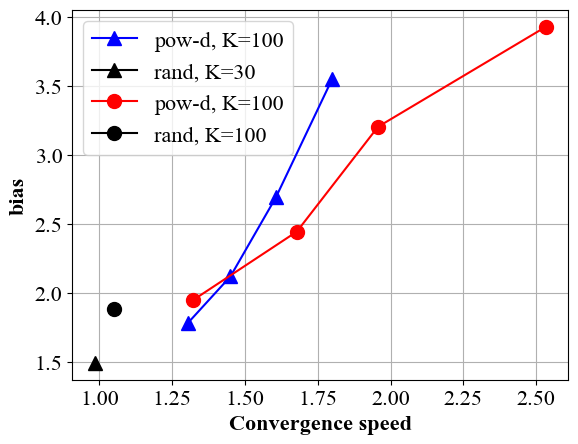

In [223]:
c_t = cm.get_cmap('tab10')
ftsize = 16
params = {'legend.fontsize': ftsize,
         'axes.labelsize': ftsize,
         'axes.titlesize':ftsize,
         'xtick.labelsize':ftsize,
         'ytick.labelsize':ftsize}
plt.rcParams.update(params)
lw = 2
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelweight'] = 'bold'
# plt.figure(figsize=(16,14.5))
plt.subplots_adjust(right=1.1, top=0.9)
rcParams['axes.titlepad'] = 14
plt.rcParams['text.usetex'] = False

plt.figure()

plt.plot([converge_powd_powd30_users30, converge_powd_powd15_users30,converge_powd_powd9_users30, converge_powd_powd6_users30],
         [bias_powd_powd30_users30, bias_powd_powd15_users30, bias_powd_powd9_users30, bias_powd_powd6_users30],
         color="b", ls="-",
         label = "pow-d, K=100",
         marker = "^",
         markersize=10)

plt.plot([converge_rand_powd30_users30],
         [bias_rand_powd30_users30],
         color="k", ls="-",
         label = "rand, K=30",
         marker = "^",
         markersize=10)

plt.plot([converge_powd_powd100_users100, converge_powd_powd50_users100, converge_powd_powd30_users100, converge_powd_powd15_users100],
         [bias_powd_powd100_users100, bias_powd_powd50_users100, bias_powd_powd30_users100, bias_powd_powd15_users100],
         color="r",
         ls="-",
         label = "pow-d, K=100", 
         marker=".", 
         markersize=20)

plt.plot([converge_rand_powd100_users100],
         [bias_rand_powd100_users100],
         color="k", ls="-",
         label = "rand, K=100",
         marker = ".", 
         markersize=20)

plt.xlabel("Convergence speed")
plt.ylabel("bias")
legend_properties = {'weight':'bold'}
plt.xticks()
plt.yticks()
plt.legend()
plt.grid()
# plt.title('K=30, m={}'.format(sample_ratio))
plt.show()

In [221]:
[converge_powd_powd30_users30, converge_powd_powd15_users30,converge_powd_powd9_users30, converge_powd_powd6_users30], [bias_powd_powd30_users30, bias_powd_powd15_users30, bias_powd_powd9_users30, bias_powd_powd6_users30]

([1.7992720342742565,
  1.6059669154219918,
  1.4500730057287268,
  1.3051919095414575],
 [3.547308532086846,
  2.6898371272764035,
  2.117556857452104,
  1.7828752539001962])

In [220]:
[converge_powd_powd100_users100, converge_powd_powd50_users100, converge_powd_powd30_users100, converge_powd_powd15_users100], [bias_powd_powd100_users100, bias_powd_powd50_users100, bias_powd_powd30_users100, bias_powd_powd15_users100]

([2.5319241373698866,
  1.9567032840949559,
  1.6778702496375284,
  1.3206347714306235],
 [3.925132215779272,
  3.2017548591020044,
  2.4422258564317265,
  1.9445268273006964])

In [219]:
[converge_rand_powd100_users100], [bias_rand_powd100_users100], [converge_rand_powd30_users30], [bias_rand_powd30_users30]

([1.0518982195083704],
 [1.8824145441131515],
 [0.9841802108778994],
 [1.49111606669216])